In [1]:
using Pkg

In [2]:
Pkg.activate(dirname(pwd()))

  Activating project at `~/Documents/GitHub/ComputationalHeatTransfer.jl`


In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using JLD2
using Plots
gr()  


┌ Info: Precompiling ComputationalHeatTransfer [5fc296c8-2eb5-40dc-a46d-98a68011a900]
└ @ Base loading.jl:1662


Plots.GRBackend()

## Control Console

In [4]:
Rn = 3e-6
δfilm = 1e-5
ad_fac = 1.3
plate_d = 1.5e-3;
Eratio = 0.15

0.15

In [5]:
fluid_type = "Butane"
Tref = 291.2

291.2

In [6]:
power = 40 #watts
hc = 2500.0
Tc = Tref;

# Properies

### Solid Physical parameters

In [7]:
ρₛ = 2730; # density
cₛ  = 8.93e02; # specific heat
kₛ  = 1.93e02; # heat conductivity
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

### Fluid Physical parameters

In [8]:
p_fluid = SaturationFluidProperty(fluid_type,Tref);

# Plate Conduction

### Geometry parameters

In [9]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [10]:
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits
Δx,Δt_max = setstepsizes(params.α,gridPe=8.0,fourier=0.3)

(0.0006333345639056725, 0.001520002953373614)

## Set up the OHP

In [11]:
OHPtype = "ASETS-II OHP 2 LARGE HEATER"

"ASETS-II OHP 2 LARGE HEATER"

In [12]:
eparams,cparams = OHPConfiguration(OHPtype,power,Tc,hc,Δx,hc2ratio=1/10);

In [13]:
x, y, xf, yf = construct_ohp_curve("ASETS",Δx)
ohp = BasicBody(x,y)
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{4877, RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

In [14]:
# plot(ohpgeom.body,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

### create HeatConduction system

In [15]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt_max,qline=ohpgeom,qflux=eparams,qmodel=cparams)

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


# OHP inner part

### Tube geometries

In [16]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = 133.83*1e-3 # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

N=numpts(ohp);

In [17]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,gravity,closedornot,N,fluid_type);

### Liquid

In [18]:
Nu = 3.60
Hₗ = p_fluid.kₗ/tube_d * Nu # Nusselt number 4.36

387.3775707791756

In [19]:
X0,realratio = randomXp(tube,30)
# X0 = [(1.0,2.0);(2.5,3.5)]
dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r);

In [20]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tref,L);

In [21]:
liquids=Liquid(Hₗ,p_fluid.ρₗ,p_fluid.Cpₗ,p_fluid.αₗ,p_fluid.μₗ,p_fluid.σ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [22]:
# Hᵥ = p_fluid.kᵥ/tube_d * Nu # Nusselt number 4.36
Hᵥ = 0.0 # Nusselt number 4.36

0.0

In [23]:
P = 0*zeros(length(X0)) .+ TtoP(Tref);
# δ = 0*zeros(length(X0)) .+ 1.0e-5;
δfilm_deposit = δfilm;
δstart = 0*zeros(length(X0)) .+ δfilm ;
δend = 0*zeros(length(X0)) .+ δfilm ;

Lvaporplug = XptoLvaporplug(X0,L,tube.closedornot)
Lfilm_start = 0.25 .* Lvaporplug
Lfilm_end = 0.25 .* Lvaporplug
# Eratio = 0.75
# δratio = 0*zeros(length(X0)) .+ 0.99;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δmin = 2e-6
vapors=Vapor(Hᵥ,p_fluid.kₗ,δmin,Eratio,P,δfilm_deposit,δstart,δend,Lfilm_start,Lfilm_end);

### Wall

### nucleate boiling sites

In [24]:
ΔTthres = RntoΔT(Rn,Tref,fluid_type,tube_d)

1.40436165473792

In [25]:
nucleatenum = 1000
Xstations = sort(rand(nucleatenum) .* L);
Xstation_time = zeros(nucleatenum);

In [26]:
boil_type = "wall T"
L_newbubble = 4tube_d
# boil_interval = L_to_boiltime(L_newbubble,Rn,fluid_type,vapors::Vapor,tube::Tube)
boil_interval = 2.0
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tref);
θwallarray .= Tref

wall = Wall(fluid_type,boil_type,boil_interval,Rn,L_newbubble,Xstations,Xstation_time,Xwallarray,θwallarray);

In [27]:
boil_interval

2.0

In [28]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [29]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [30]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = getMvapor(sys0)

u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
# u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [31]:
function immersedboundary_condition(u,t,integrator)
    true
end

immersedboundary_condition (generic function with 1 method)

In [32]:
function immersedboundary_affect!(integrator)
    integrator.p.wall.θarray = deepcopy(temperature_linesource(Main.integrator_plate))
end

immersedboundary_affect! (generic function with 1 method)

In [33]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
cb_vapormerging =  DiscreteCallback(merging_condition,merging_affect!)
cb_liquidmerging = DiscreteCallback(vaporMergingCondition,vaporMergingAffect!)
cb_fixdx =  DiscreteCallback(fixdx_condition,fixdx_affect!)
cbst = CallbackSet(cb_fixdx,cb_boiling,cb_vapormerging,cb_liquidmerging);

# combine inner tube and plate together

In [34]:
tspan = (0.0, 300.0);
num_data = 300
dt_record = tspan[2] /num_data;

tstep = 5e-4

0.0005

In [35]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
temperature(integrator_plate) .= Tref;

In [36]:
p = sys0
u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_on=false, dt=tstep, callback=cbst);
currentsys = getcurrentsys(integrator_tube.u,integrator_tube.p);
currentsys.wall.θarray = deepcopy(temperature_linesource(integrator_plate));

## Resume

In [37]:
# integrator_plate = integrator_plate_temp;

In [38]:
# integrator_tube = tube_hist[end];

## Start

In [39]:
boil_hist=[]
plate_T_hist = []
tube_hist_u  = []
tube_hist_t = []
tube_hist_θwall = []

Any[]

In [40]:
using Distributed
using ProgressMeter

In [41]:
prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t,integrator_plate.t+tspan[2]-tspan[1]), currentsys)
integrator_tube = init(prob, RK4(),maxiters=1e8,callback=cbst, dt=tstep,save_on=false);

@showprogress for t in tspan[1]:tstep:tspan[2]
# @time for t in tspan[1]:tstep:tspan[1]
     step!(integrator_tube,tstep,true);

        currentsys = deepcopy(getcurrentsys(integrator_tube.u,integrator_tube.p))
        currentsys.wall.θarray = deepcopy(temperature_linesource(integrator_plate))
        integrator_tube.p = deepcopy(currentsys)
        qtmp = deepcopy(sys_to_heatflux(currentsys))
       set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)

    integrator_plate.t += tstep
    
    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_T_hist,deepcopy(temperature(integrator_plate))); 
        push!(tube_hist_θwall,deepcopy(integrator_tube.p.wall.θarray))
        push!(tube_hist_u,deepcopy(integrator_tube.u));
        push!(tube_hist_t,deepcopy(integrator_tube.t));
        integrator_plate_temp = deepcopy(integrator_plate)
#         println(sys.qline[1].q[1:5])
    end
    
end
# integrator_plate.t

Progress:   4%|█▊                                       |  ETA: 4:03:34m38m

reconstruct dx! in5 at 12.517500000003807


Progress:   4%|█▊                                       |  ETA: 4:04:43

reconstruct dx! in8 at 13.181000000004618


Progress:   4%|█▊                                       |  ETA: 4:04:30

vapor merged!


Progress:   4%|█▊                                       |  ETA: 4:04:31

4.287964385787111e-6
0.0013590708361902295
0.0013547828718044423


Progress:   5%|██                                       |  ETA: 4:13:03

reconstruct dx! in6 at 14.978000000006814


Progress:   6%|██▍                                      |  ETA: 5:35:12

pure vapor too short


Progress:   8%|███▏                                     |  ETA: 5:15:53

reconstruct dx! in1 at 22.52943611242651


Progress:   8%|███▌                                     |  ETA: 5:12:21

vapor merged!
5.734884796274519e-6
0.0013586305444812966
0.0013528956596850221


Progress:  12%|████▉                                    |  ETA: 5:43:06

reconstruct dx! in1 at 36.07849999999024


Progress:  12%|█████                                    |  ETA: 5:41:24

reconstruct dx! in7 at 36.620171801791805


Progress:  12%|█████▏                                   |  ETA: 5:39:16

reconstruct dx! in6 at 37.47231436554204


Progress:  17%|██████▉                                  |  ETA: 5:02:05

reconstruct dx! in9 at 50.25522155942189


Progress:  18%|███████▌                                 |  ETA: 4:51:42

LoadError: InterruptException:

In [52]:
sysfinal = []
for i = 1:length(tube_hist_u)
    sysfinaltemp = deepcopy(getcurrentsys(tube_hist_u[i],integrator_tube.p))
    sysfinaltemp.wall.θarray = tube_hist_θwall[i]
     push!(sysfinal, sysfinaltemp)
end

In [53]:
boil_hist

493-element Vector{Any}:
 [409.0, 2.4799999999999955]
 [338.0, 5.099999999999893]
 [957.0, 5.469999999999688]
 [143.0, 5.559999999999638]
 [958.0, 5.559999999999638]
 [909.0, 5.759999999999527]
 [141.0, 5.769999999999522]
 [231.0, 5.779999999999516]
 [236.0, 6.039999999999372]
 [238.0, 6.07999999999935]
 [978.0, 6.07999999999935]
 [407.0, 6.369999999999189]
 [409.0, 6.469999999999134]
 ⋮
 [263.0, 54.840000000079826]
 [260.0, 54.86000000007992]
 [673.0, 54.97000000008045]
 [672.0, 55.00000000008059]
 [308.0, 55.020000000080685]
 [676.0, 55.03000000008073]
 [312.0, 55.060000000080876]
 [677.0, 55.060000000080876]
 [667.0, 55.09000000008102]
 [315.0, 55.10000000008107]
 [317.0, 55.150000000081306]
 [320.0, 55.21000000008159]

In [45]:
sysfinal[end].liquid.dXdt

23-element Vector{Tuple{Float64, Float64}}:
 (-0.7686848916687561, -0.7686848916687561)
 (-0.501829001143729, -0.501829001143729)
 (-0.8811774612875756, -0.8811774612875756)
 (-0.8423533797787672, -0.8423533797787672)
 (-0.8423533797787672, -0.8423533797787672)
 (-0.17855895883843492, -0.17855895883843492)
 (-0.12748414246025075, -0.12748414246025075)
 (-0.008991356282514415, -0.008991356282514415)
 (0.29152875095354563, 0.29152875095354563)
 (0.45164717716800795, 0.45164717716800795)
 (0.8089554505412441, 0.8089554505412441)
 (1.0047058581643198, 1.0047058581643198)
 (0.8473905137449852, 0.8473905137449852)
 (1.1165925466990616, 1.1165925466990616)
 (1.1888245204191144, 1.1888245204191144)
 (-0.07144735224244159, -0.07144735224244159)
 (-0.07385895675938266, -0.07385895675938266)
 (-0.0828421906664028, -0.0828421906664028)
 (-0.08505796223001123, -0.08505796223001123)
 (-0.02305117978745137, -0.02305117978745137)
 (-0.08160925550026127, -0.08160925550026127)
 (0.16089010521372302, 0.1

In [46]:
sysfinal[end].vapor.δend

23-element Vector{Float64}:
 2.4260516277715523e-5
 2.6392780939371022e-5
 2.4750538085565497e-5
 4.9999948895863136e-5
 5.0e-5
 1.6235019815747133e-5
 2.026412566072044e-5
 2.4594156597454857e-5
 1.9048400457878214e-5
 2.0745631548537186e-5
 1.9764896185390813e-5
 1.971747879036403e-5
 2.0612806671076703e-5
 1.9884229811735032e-5
 2.0514994939350465e-5
 2.1673718193371193e-5
 1.991888957129714e-5
 1.971720917914074e-5
 1.9018713616642574e-5
 1.8008785951911362e-5
 3.0339902485883275e-5
 1.87204726882342e-5
 1.760631972256225e-5

In [47]:
sysfinal[end].vapor.δstart

23-element Vector{Float64}:
 2.2028612571909396e-5
 1.7931024991855663e-5
 2.3430453485764136e-5
 2.0588416404731033e-5
 5.0e-5
 1.7329122201360226e-5
 2.7473632655118553e-5
 2.092205782398208e-5
 2.0531395706825773e-5
 2.3493411971121767e-5
 2.304430603788252e-5
 1.616193145275328e-5
 1.7709876620645078e-5
 1.3162949811925786e-5
 2.3234292237646566e-5
 2.535917558693396e-5
 2.2097711843542792e-5
 2.086118578788903e-5
 2.1596809524634082e-5
 1.92206119656116e-5
 1.9825312250911028e-5
 2.51592367260813e-5
 2.8340628139104e-5

In [48]:
sysfinal[end].vapor.Lfilm_end

23-element Vector{Float64}:
 0.04018619738954402
 0.0007431054871960109
 0.048813912071296206
 0.00038081928296057003
 0.0007637265240416178
 0.013810632461135862
 0.11543426374372985
 0.04154058790460667
 0.04331087564266159
 0.04332781896456827
 0.04883362432358293
 0.02513789055074582
 0.016972184502255187
 0.036792350891071364
 0.006433999339082022
 0.1168317226929837
 0.00039525231622825985
 0.00039346506424511055
 0.00039981439318583677
 0.0003876886497512492
 0.013324508632496894
 0.0020817152342177485
 0.0025456703385496084

In [49]:
sysfinal[end].vapor.Lfilm_start

23-element Vector{Float64}:
 0.09125483871372322
 0.11082176668680847
 0.12007930579077074
 0.0019104703213678846
 0.0007637265240416178
 0.06188617989551343
 0.15598589870040694
 0.10811493041749946
 0.12263592828369334
 0.09801101967170174
 0.11135109077922414
 0.000368864882711004
 0.00037747954084922056
 0.0003904530246645147
 0.0003878509375025456
 0.05878237438687414
 0.004723587933536998
 0.0013543203011699796
 0.004321456931000296
 0.0062880866804625795
 0.004590865431862693
 0.035090364944067864
 0.2935563468061616

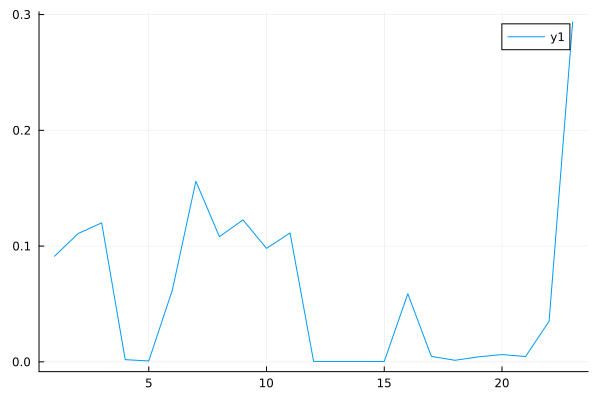

In [50]:
plot(sysfinal[end].vapor.Lfilm_start)

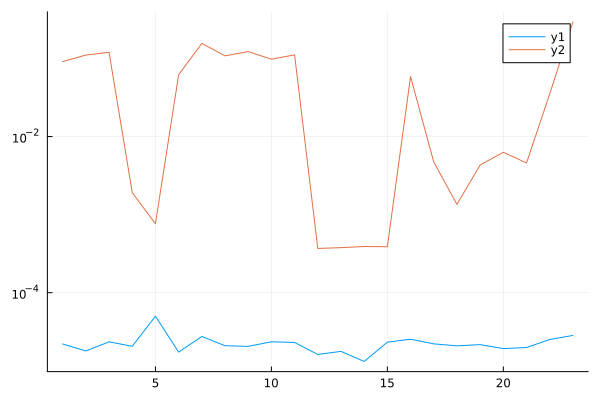

In [51]:
plot(sysfinal[end].vapor.δstart)
plot!(sysfinal[end].vapor.Lfilm_start,yscale=:log10)

In [ ]:
plot(sys0,ylim=(291,293))

In [ ]:
anim = @animate for i=1:length(sysfinal)
    plot(sysfinal[i],ylim=(291,300))
end
gif(anim, "slug_fps15.gif", fps = 10)

┌ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/slug_fps15.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/kYFLA/src/animation.jl:149


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/slug_fps15.gif")
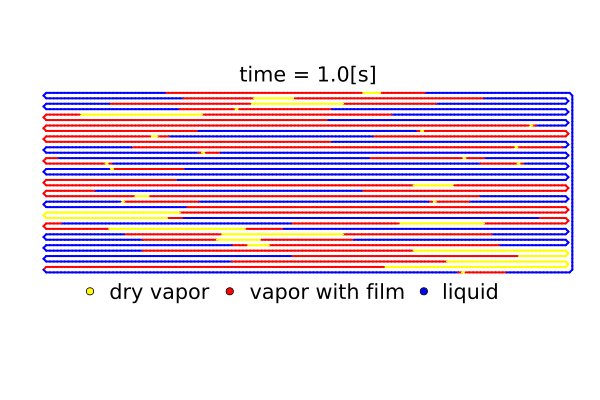

In [62]:
gr()
Hₗ = sysfinal[1].liquid.Hₗ
adjust = 1e-2;

anim = @animate for i=1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
        annotate!(0.0, 0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false)
    scatter!([-0.066+adjust],[-0.028],color=:yellow);scatter!([-0.03+adjust],[-0.028],color=:red);scatter!([0.02+adjust],[-0.028],color=:blue);
    annotate!(-0.05+0.002+adjust, -0.028, "dry vapor", :black)
    annotate!(-0.01+0.005+adjust, -0.028, "vapor with film", :black)
    annotate!(0.03+0.002+adjust, -0.028, "liquid", :black)
end
gif(anim, "slug_fps15.gif", fps = 10)

In [63]:
cp = cparams[1]

PrescribedHeatModelRegion{Rectangle{186, RigidBodyTools.Unshifted}}(250.0, 291.2, Rectangular body with 186 points and half-lengths (0.01397,0.0324)
   Current position: (-0.0635,-0.0)
   Current angle (rad): 0.0
)

┌ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/temperature_fps15.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/kYFLA/src/animation.jl:149


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/temperature_fps15.gif")
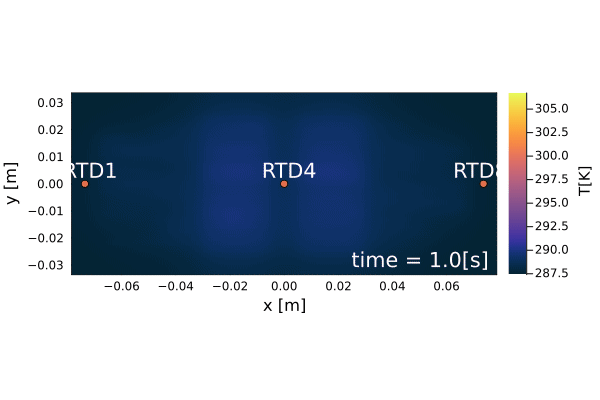

In [64]:
    x = [-2.9inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.9inch]
    y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
gr()
Tmax = maximum(plate_T_hist[end]) .- 3.8
Tmin = minimum(plate_T_hist[1]) .- 3.8
xlim = integrator_plate.p.grid.xlim[1]
ylim = integrator_plate.p.grid.xlim[2]

anim = @animate for i = 1:1:length(sysfinal)
# anim = @animate for i = 1:1:1
# @gif for i = 1:1:1
heatmap(plate_T_hist[i].- 3.8,sys.grid,legend=true,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",
        colorbar_title = "\n T[K]",right_margin = 5Plots.mm)
#     plot!(cparams[1].body)
#     plot!(cparams[2].body)
#     plot!(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),
#         line_z=0,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
#         annotate!(0.0, 0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false)
   
scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :white)
annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :white)
annotate!(x[8]-0.001, y[8]+0.005, "RTD8", :white)
annotate!(0.05, -0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white,legend=false)

end
gif(anim, "temperature_fps15.gif", fps = 30)

In [65]:
using XLSX
# namei = "20190604_F_PD_%23005_O002_H001_P010_expA.xlsx"
# namei = "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx"
# namei = "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx"
namei = "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx"
# namei = "20190613_F_PD_%23004_O001_H001_P040_expA.xlsx"
# namei = "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx"
# namei =     "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx";
#  namei =    "20190606_F_PD_%23002_O001_H001_P020_expA.xlsx";

xf = XLSX.readxlsx(dirname(dirname(dirname(pwd())))*"/OHPexp/"*namei)
    Onum, Hnum, power_exp = getconfig(namei)
    RTD,RTDt = getRTD(xf,Onum);

In [66]:
    
    x = [-2.9inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.9inch]
    y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
    X =  VectorData(x,y);
    H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
    g = ScalarData(X);
    ghist = getghist(g,H,plate_T_hist);
    thist = tube_hist_t;

In [67]:
Tᵥ = Tref

291.2

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


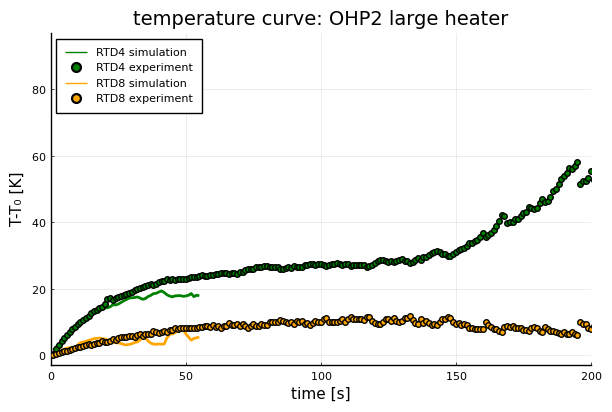

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/temp_curve.pdf"

In [68]:
pyplot()
# i = 1 #RTD number

# p1 = plot(thist,ghist[i] .-Tᵥ, color=:red, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
# scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:red, label=string("RTD", i," experiment"))

i = 4 #RTD number

p1 = plot(thist,ghist[i] .-Tᵥ, color=:green, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:green, label=string("RTD", i," experiment"))

i = 8 #RTD number
plot!(thist,ghist[i] .-Tᵥ,color=:orange,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:orange, label=string("RTD", i," experiment"),
    xlabel="time [s]",ylabel="T-T₀ [K]",xlim=(0,200),title=("temperature curve: OHP2 large heater"))

savefig(p1,"temp_curve.pdf")

In [ ]:
sysfinal[200].liquid.Xp

In [ ]:
XptoLliquidslug(sysfinal[end].liquid.Xp,L) - XptoLliquidslug(sysfinal[1].liquid.Xp,L)

## total mass

In [54]:
M1 = sum.(getMvapor.(sysfinal));
M2 = sum.(sum.(getMfilm.(sysfinal)));
M3 = sum.(getMliquid.(sysfinal));

In [55]:
M1 ./ M3

55-element Vector{Float64}:
 0.009402585676309055
 0.00987851658463325
 0.010115706239873868
 0.01028185743419007
 0.010524601850312214
 0.01076612686914378
 0.011057398011089122
 0.01127288997449567
 0.011505200163091934
 0.011598241248367945
 0.011891772628571936
 0.012023096587040568
 0.012496436406453797
 ⋮
 0.015266526837491854
 0.015326438119278389
 0.015354224886390776
 0.015185877621767763
 0.015244852026961683
 0.015488969859625862
 0.015690141303213244
 0.015796358207927408
 0.01589012776283007
 0.01578130498050611
 0.01571811112754774
 0.015754360992605236

In [56]:
Mtotal = M1 .+ M2 .+ M3;
M0 = Mtotal[1]

0.0013593623282852532

In [57]:
Mtotal

55-element Vector{Float64}:
 0.0013593623282852532
 0.0013592981046653086
 0.0013592734351954591
 0.001359256832300873
 0.0013592505680900592
 0.001359245445383363
 0.0013592338681882345
 0.0013592212324884936
 0.001359171562672678
 0.0013591474186598086
 0.0013590901103369183
 0.0013590870540724708
 0.001359052141664767
 ⋮
 0.001358442182867814
 0.0013584226875696668
 0.001358383183978207
 0.0013583542831420313
 0.0013583180410422547
 0.0013583281565102525
 0.001358282340261551
 0.0013582007112500662
 0.0013582043185142293
 0.0013581899922127435
 0.001358172453013983
 0.0013581573636556902

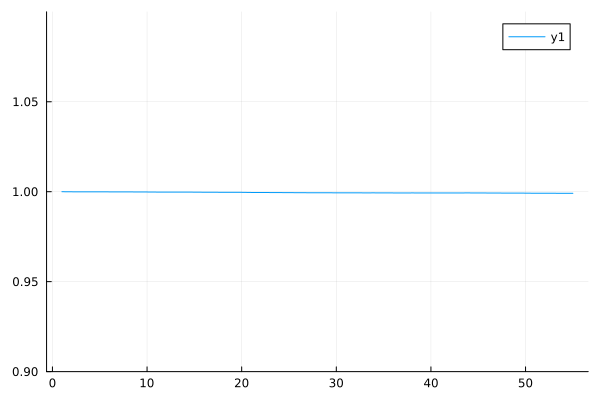

In [61]:
plot(Mtotal/M0,ylim=(0.9,1.1))

# Relative system mass over time

In [ ]:
plot(0.1:0.1:10,Mtotal/M0,xlabel="time [s]",ylabel="relative mass",legend=false,ylim=(0.99,1.01))
# plot!(M3/M0,xlabel="timestep",ylabel="relative mass",legend=false)
# plot!((M2+M3)/M0,xlabel="timestep",ylabel="relative mass",legend=false)

In [589]:
max_error = maximum(1 .- Mtotal/M0)

0.02655055042185306

In [590]:
Lliquidslug_old = XptoLliquidslug(sysfinal[159].liquid.Xp,sysfinal[end].tube.L)

6-element Vector{Float64}:
 0.18199316927676912
 0.1479647793061467
 0.2008174364245341
 0.0318468955064537
 0.9071197233061516
 0.4143747982582693

In [596]:
ptest = vaporMerging(sysfinal[end],3);

    Mvapor_new = getMvapor(ptest);
    Mfilm_new = sum(getMfilm(ptest));
    Mliquid_new = getMliquid(ptest);
    
    Mnew = sum(Mvapor_new + Mfilm_new + Mliquid_new)

# ptest.liquid.Xp

3.3956059377089533e-5
0.0011821756754821717
0.0011482196161050821


0.0011821756754821712

In [597]:
Mtotal[end]

0.0011821756754821714

In [598]:
Mnew

0.0011821756754821712

In [599]:
Mtotal[end]/Mnew

1.0000000000000002

## Store data

In [ ]:
using JLD2

In [ ]:
boil_station_hist = [elem[1] for elem in boil_hist]
boil_t_hist = [elem[2] for elem in boil_hist]
boil_data = Array(reshape([boil_station_hist;boil_t_hist], length(boil_t_hist),2));

In [ ]:
save(dirname(dirname(dirname(pwd())))*"/OHPnume/OHP4_40W_E030_1_DT1_large.jld2",
    "tube_hist_θwall", tube_hist_θwall,"tube_hist_u", tube_hist_u,"tube_hist_t", tube_hist_t,
    "integrator_tube",integrator_tube,"plate_T_hist", plate_T_hist,
    "integrator_plate", integrator_plate, "boil_data", boil_data,"ohp",ohp)